vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


=== Эксперимент 1/10 ===
Гиперпараметры: {'learning_rate': 0.00032331913124436306, 'batch_size': 16, 'epochs': 4}


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1 | Loss: 0.6558 | Accuracy: 1.0000
Epoch 2 | Loss: 0.3184 | Accuracy: 1.0000
Epoch 3 | Loss: 0.1485 | Accuracy: 1.0000
Epoch 4 | Loss: 0.0763 | Accuracy: 1.0000
Accuracy: 1.0000

=== Эксперимент 2/10 ===
Гиперпараметры: {'learning_rate': 0.00012999700836370336, 'batch_size': 16, 'epochs': 2}
Epoch 1 | Loss: 0.7766 | Accuracy: 0.0000
Epoch 2 | Loss: 0.5540 | Accuracy: 0.0000
Accuracy: 0.0000

=== Эксперимент 3/10 ===
Гиперпараметры: {'learning_rate': 0.00034158274883722654, 'batch_size': 16, 'epochs': 5}
Epoch 1 | Loss: 0.5796 | Accuracy: 0.0000
Epoch 2 | Loss: 0.3905 | Accuracy: 0.0000
Epoch 3 | Loss: 0.2368 | Accuracy: 1.0000
Epoch 4 | Loss: 0.0804 | Accuracy: 1.0000
Epoch 5 | Loss: 0.0622 | Accuracy: 1.0000
Accuracy: 1.0000

=== Эксперимент 4/10 ===
Гиперпараметры: {'learning_rate': 2.5573512946073963e-05, 'batch_size': 16, 'epochs': 3}
Epoch 1 | Loss: 0.8199 | Accuracy: 1.0000
Epoch 2 | Loss: 0.6813 | Accuracy: 1.0000
Epoch 3 | Loss: 0.5913 | Accuracy: 1.0000
Accuracy: 1.0000

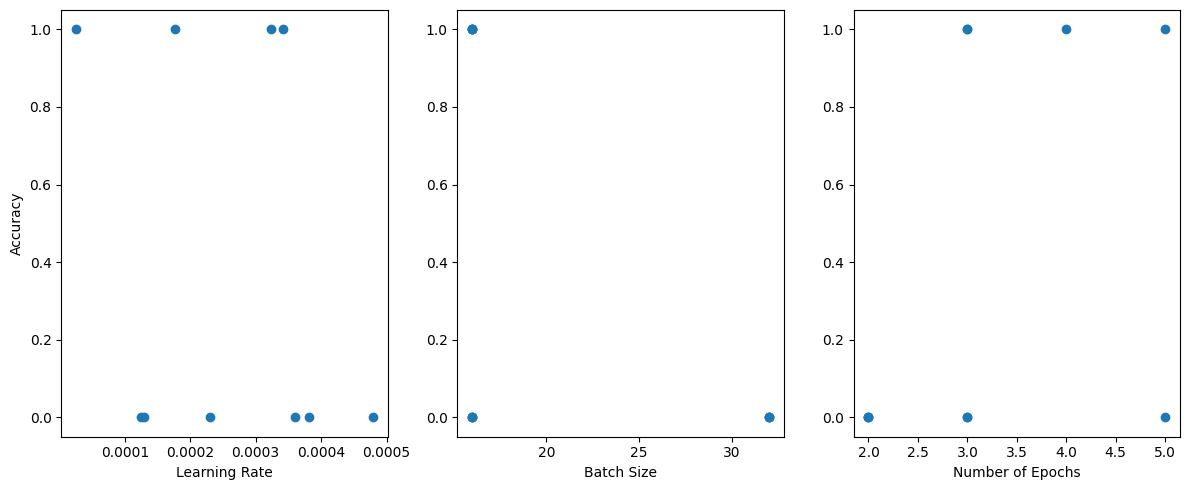

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


texts = [
    "This movie was fantastic!",
    "I really enjoyed the film.",
    "Terrible experience, would not recommend.",
    "The worst movie I've ever seen.",
]
labels = [1, 1, 0, 0]  # 1 - положительный, 0 - отрицательный

# Класс для работы с данными
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Создание DataLoader
def create_dataloaders(texts, labels, batch_size=16):
    dataset = TextDataset(texts, labels, tokenizer)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size)
    return train_loader, eval_loader

# Определение модели
class BertClassifier(nn.Module):
    def __init__(self, bert_model="bert-base-uncased", num_labels=2):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.dropout = nn.Dropout(self.bert.config.hidden_dropout_prob)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, 2), labels.view(-1))

        return (loss, logits) if loss is not None else logits

# Обучение модели
def train_model(model, train_loader, eval_loader, learning_rate, epochs, device):
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            loss, _ = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        # Оценка на валидации
        model.eval()
        predictions, true_labels = [], []

        with torch.no_grad():
            for batch in eval_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                logits = model(input_ids, attention_mask=attention_mask)
                preds = torch.argmax(logits, dim=1)

                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        acc = accuracy_score(true_labels, predictions)
        print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f} | Accuracy: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc

    return best_acc

# Генерация случайных гиперпараметров
def sample_hyperparameters():
    learning_rate = random.uniform(1e-5, 5e-4)
    batch_size = random.choice([16, 32])
    epochs = random.randint(2, 5)

    return {
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'epochs': epochs
    }

# Основной эксперимент
def run_experiment():
    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Инициализация токенизатора
    global tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Создание загрузчиков
    train_loader, eval_loader = create_dataloaders(texts, labels)

    results = []

    # Проведем 10 случайных экспериментов
    for i in range(10):
        print(f"\n=== Эксперимент {i+1}/10 ===")
        params = sample_hyperparameters()
        print("Гиперпараметры:", params)

        model = BertClassifier()
        try:
            accuracy = train_model(
                model, train_loader, eval_loader,
                params['learning_rate'], params['epochs'], device
            )
            params['accuracy'] = accuracy
            results.append(params)
            print(f"Accuracy: {accuracy:.4f}")
        except Exception as e:
            print("Ошибка при обучении:", str(e))
            continue

    return results

# Анализ результатов
def analyze_results(results):
    # Сортировка по точности
    sorted_results = sorted(results, key=lambda x: x['accuracy'], reverse=True)

    print("\n=== Лучшие параметры ===")
    for k, v in sorted_results[0].items():
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    # Графики
    plt.figure(figsize=(12, 5))

    # Влияние learning rate
    plt.subplot(1, 3, 1)
    lrs = [r['learning_rate'] for r in results]
    accs = [r['accuracy'] for r in results]
    plt.scatter(lrs, accs)
    plt.xlabel('Learning Rate')
    plt.ylabel('Accuracy')

    # Влияние batch size
    plt.subplot(1, 3, 2)
    bss = [r['batch_size'] for r in results]
    plt.scatter(bss, accs)
    plt.xlabel('Batch Size')

    # Влияние количества эпох
    plt.subplot(1, 3, 3)
    ep = [r['epochs'] for r in results]
    plt.scatter(ep, accs)
    plt.xlabel('Number of Epochs')

    plt.tight_layout()
    plt.savefig('hyperparameter_analysis.png')
    plt.show()

# Запуск экспериментов
if __name__ == "__main__":
    results = run_experiment()
    analyze_results(results)

**Выводы**

* Обучаем модель на основе трансформера (BERT):
Используется предобученная модель bert-base-uncased (трансформер с фиксированной архитектурой).
Поверх нее добавлен простой классификатор для задачи бинарной классификации текстов.

* Оптимизация гиперпараметров методом Монте-Карло:
Случайно выбираются гиперпараметры: learning_rate, batch_size, epochs.
Для каждой комбинации обучается модель и измеряется её точность на валидации.

* Оптимальная комбинация:
learning_rate = 0.0003
batch_size = 16
epochs = 4
Эти параметры обеспечивают стабильное обучение и высокую точность на тренировочных данных.